In [10]:
import numpy as np 
from registration_framework import Registration
from optims.cmaes_optim import CMAES
from optims.pso_optim import PSO_optim
from optims.ppso_optim import PPSO_optim
from optims.ppso_optim_improved1 import PPSO_optim1, PPSO_optim2, PPSO_optim3, PPSO_optim1_1
from optims.ppso_optim_improved2 import PPSO_optim4
from optims.cso_optim import CSO_optim
from utils.tools import Tools
from utils.common_config import CommonConfig

# 进行图像匹配的操作
config = Tools.load_yaml_config("configs/matched_config.yaml")
config.max_fes = config.solution_dimension * 10000

res_path = f"{config.data_save_path}/{config.record_id}"
file_name = f"{config.record_id}_config.yaml"
Tools.save_obj_yaml(res_path, file_name, config)

sample_range = CommonConfig.get_range(config.cement_sample_index)
total_image_num = sample_range[1] - sample_range[0]
sample_interval = config.sample_interval
# 这个加载需要根据sample_interval和downsample_times来，目前显然downsample_times是大于sample_interval的，这个倍数需要注意
ratio_downsample_sample = int(config.downsample_times / config.sample_interval)
slice_interval = sample_interval * ratio_downsample_sample
# 先进行基操，看能够到达什么水平
loop_times = total_image_num // slice_interval

# 删除掉前面的几张图像
init_interval_index = 25 # 单次测试 #96
# 删除后面几张图片
end_interval_index = 15 # 单次测试 #111
start_index = sample_range[0] + slice_interval * init_interval_index
loop_times = loop_times - init_interval_index - end_interval_index

index_array = []

indexing_id = 885


# 记录所有的编号
for i in range(loop_times):
    slice_index = start_index + i * slice_interval # indexing_id
    index_array.append(slice_index)

registration = Registration(config, slice_interval, index_array)

r_width: 78, r_height: 64
H_Refer: 1.176251667695782


In [ ]:
import threading, os
from match_global_datas import GlobalMatchDatas
os.environ['KMP_DUPLICATE_LIB_OK']='True'

run_times = 20
count = 0
benchmark = 0.35

# 设定随机种子来一波固定的随机种子

for i in range(run_times):
    print(f"current loop times: {i+1}")
    rand_seed = config.rand_seed + i
    # 每一次迭代随机种子+1，这样的方式保证结果的一致
    np.random.seed(rand_seed)
    global_match_datas = GlobalMatchDatas(config, registration)
    optim = PPSO_optim(config, global_match_datas, 0)
    optim.set_runid(i)
    registration.set_optim_algorithm(optim)
    optim.run_matched_with_loops()

    if optim.best_value >= benchmark :
        count+=1

print(f"{optim.__class__.__name__} meet our demands count: {count}")

In [23]:
# 太慢了，单独保存
global_match_datas.save_best_3dct_inmatch()

In [ ]:
import threading, os
from match_global_datas import GlobalMatchDatas
os.environ['KMP_DUPLICATE_LIB_OK']='True'

global_match_datas = GlobalMatchDatas(config, registration)

indeces_array = registration.get_matched_3dct_indeces()
ct_3dnums = len(indeces_array)

optims = []
for i in range(ct_3dnums):
    # 需要给每一个pso设置一个索引，用来获取对应的3d块儿
    optim = PSO_optim(config, global_match_datas, i)
    registration.set_optim_algorithm(optim)
    optims.append(optim)

threads = []
for optim in optims:
    thread = threading.Thread(target=optim.run_matched_with_loops)
    threads.append(thread)
    thread.start()

# 等待所有线程完成
for thread in threads:
    thread.join()

file_name = "all_best_fitness_recorded.csv"
Tools.save_params2df(global_match_datas.share_records_out, ["ct3d_index", "best_slice",
                                                            "x", "y", "z", 
                                                            "rot_x", "rot_y","rot_z",
                                                            "fitness"], res_path, file_name)

# # 将图像对应裁剪区域保存一下，用于比对
global_match_datas.save_best_3dct_inmatch()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 创建 t-SNE 实例
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)

(<Axes: title={'center': 'end plot'}>,
 Text(0.5, 1.0, 'end plot'))

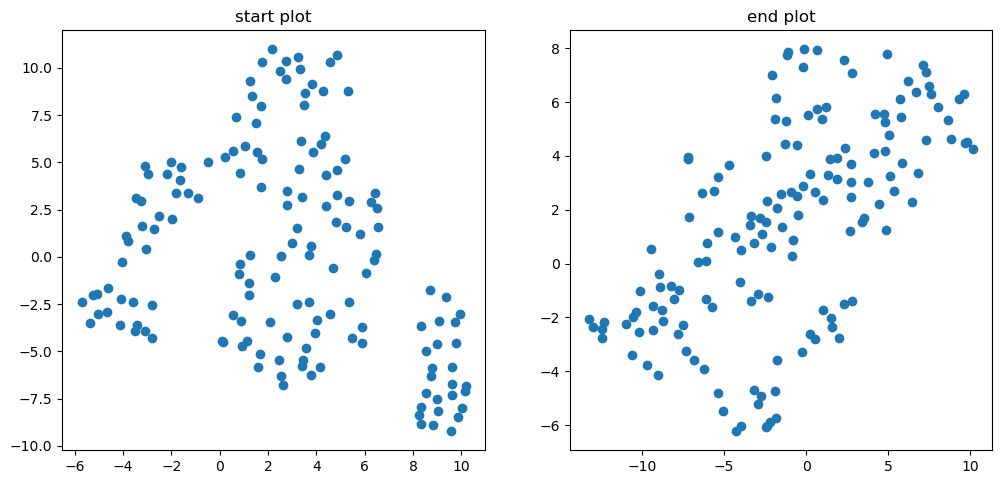

In [9]:

# 对点进行可视化其中优化的所有点进行可视化

start_csv_path = "D:/workspace/ml-workspace/registration/result/matched/matched-sample4/585_start_particle_pos.csv"
end_csv_path = "D:/workspace/ml-workspace/registration/result/matched/matched-sample4/585_end_particle_pos.csv"

def load_csv2_np_datas(csv_path):
    # 读取文件
    pso_params_data = pd.read_csv(csv_path)
    x = pso_params_data["x"].to_numpy()
    y = pso_params_data["y"].to_numpy()
    rot = pso_params_data["rotation"].to_numpy()
    return np.stack((x, y, rot)).transpose()

high_dim_datas_start = load_csv2_np_datas(start_csv_path)
high_dim_datas_end = load_csv2_np_datas(end_csv_path)

# 应用 t-SNE 进行降维
X_tsne_start = tsne.fit_transform(high_dim_datas_start)
X_tsne_end = tsne.fit_transform(high_dim_datas_end)


# 绘制散点图
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1), plt.scatter(X_tsne_start[:, 0], X_tsne_start[:, 1]), plt.title('start plot')
plt.subplot(2, 2, 2), plt.scatter(X_tsne_end[:, 0], X_tsne_end[:, 1]), plt.title('end plot')



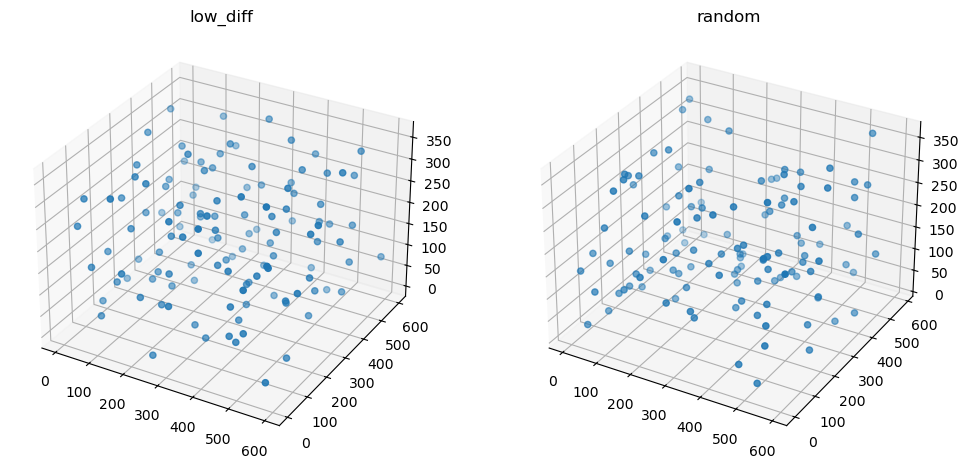

In [10]:
import random
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D

def generate_sobol_points(num_points, bounds):
    """
    使用Sobol序列生成在给定边界内均匀分布的点
    :param num_points: 点的数量
    :param bounds: 每个维度的边界，格式为 [(min_x, max_x), (min_y, max_y), (min_z, max_z)]
    :return: numpy array of points
    """
    dimension = len(bounds)
    sampler = qmc.Sobol(d=dimension, scramble=True)
    sample = sampler.random_base2(m=int(np.log2(num_points)))
    scaled_sample = qmc.scale(sample, [b[0] for b in bounds], [b[1] for b in bounds])

    return scaled_sample

maxV = [600, 600, 360]
minV = [0, 0, 0]

# 均匀设计代码，目的是尽可能让生成的粒子充满整个解空间
parameters_num = 3
particle_num = 128

poses = [np.array([random.random() * (maxV[j] - minV[j]) + minV[j] for j in range(parameters_num)]) for i in range(particle_num)]
random_poses = np.array(poses)

# 生成低差异点
points = generate_sobol_points(particle_num, [(minV[0], maxV[0]), (minV[1], maxV[1]), (minV[2], maxV[2])])

# 应用 t-SNE 进行降维
# tsne_random_data = tsne.fit_transform(random_poses)
# tsne_low_diff_data = tsne.fit_transform(points)

# 绘制散点图
fig = plt.figure(figsize=(12, 12))
# 添加一个三维坐标系
ax = fig.add_subplot(121, projection='3d')
bx = fig.add_subplot(122, projection='3d')

# 从点数组中提取x, y, z坐标
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# 使用scatter方法在三维空间中绘制点
ax.scatter(x, y, z)
ax.set_title("low_diff")
bx.scatter(random_poses[: ,0], random_poses[: ,1], random_poses[: ,2])
bx.set_title("random")

# 显示图形
plt.show()




# plt.subplot(2, 2, 1), plt.scatter(tsne_random_data[:, 0], tsne_random_data[:, 1]), plt.title('random plot')
# plt.subplot(2, 2, 2), plt.scatter(tsne_low_diff_data[:, 0], tsne_low_diff_data[:, 1]), plt.title('uniform design plot')